# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [5]:
# print the first few rows
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
# print the first few rows
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# copy feat_info
feat_info_copy = feat_info
feat_info_copy.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
# copy azdias
azdias_copy = azdias
azdias_copy.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [9]:
# 4896838 are naturally null
azdias_copy.isna().sum().sum()

4896838

In [10]:
# Code for replacing null values with np.nan are by mentor Misgana
# of Udacity

def string_to_list(x):
    """
    Function to change column from array of strings representing integers
    to numerical list while adding non-numerical strings to the list without
    changes.
    """
    missing_list=[]
    x = x[1:-1].split(',')
    for index in x:
        try:
            missing_list.append(int(index))
        except:
            missing_list.append(index)
    return missing_list

In [11]:
# Apply function string_to_list to create a new column, 'NA_tags,' for feat_info_copy
feat_info_copy['NA_tags'] = feat_info_copy['missing_or_unknown'].apply(string_to_list)                                                                       

In [12]:
feat_info_copy.head()

,attribute,information_level,type,missing_or_unknown,NA_tags
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [13]:
# Sets the index of feat_info_copy to 'attribute'
feat_info_copy = feat_info_copy.set_index('attribute')
feat_info_copy.head()

,information_level,type,missing_or_unknown,NA_tags
attribute,,,,
AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
CJT_GESAMTTYP,person,categorical,[0],[0]
FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [14]:
# make copy for clean function
clean_feat_info_copy = feat_info_copy

In [15]:
# Iterate through each column in azdias_copy
# Where the value is equal to a value in 'NA_tags' in feat_info_copy,
# replace them with np.nan
for column in azdias_copy.columns:
    azdias_copy[column].replace(feat_info_copy.loc[column].loc['NA_tags'],np.NaN,inplace=True)

In [16]:
# 8373929 are NaN after replacements
azdias_copy.isna().sum().sum()

8373929

In [17]:
azdias_copy.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [18]:
# Reset index of feat_info_copy to original index
feat_info_copy = feat_info_copy.reset_index()
feat_info_copy.head()

,attribute,information_level,type,missing_or_unknown,NA_tags
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [19]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# Create arrays for columns and percentage null
column_name_array = []
percentage_null_array = []
null_dict = {}

for (column_name, column_content) in azdias_copy.iteritems():

    are_null = column_content.isnull().sum()
    not_null = column_content.notnull().sum()
    percentage_null = are_null/(are_null+not_null)*100
    
    # append column_name and percentage null to dictionary
    null_dict[column_name] = percentage_null

In [20]:
# Investigate patterns in the amount of missing data in each column.
# Make a dataframe from null_dict
df_nulls = pd.DataFrame(list(null_dict.items()), columns = ['Columns', 'Nulls'])
df_nulls.head()

,Columns,Nulls
0,AGER_TYP,76.955435
1,ALTERSKATEGORIE_GROB,0.323264
2,ANREDE_KZ,0.000000
3,CJT_GESAMTTYP,0.544646
4,FINANZ_MINIMALIST,0.000000


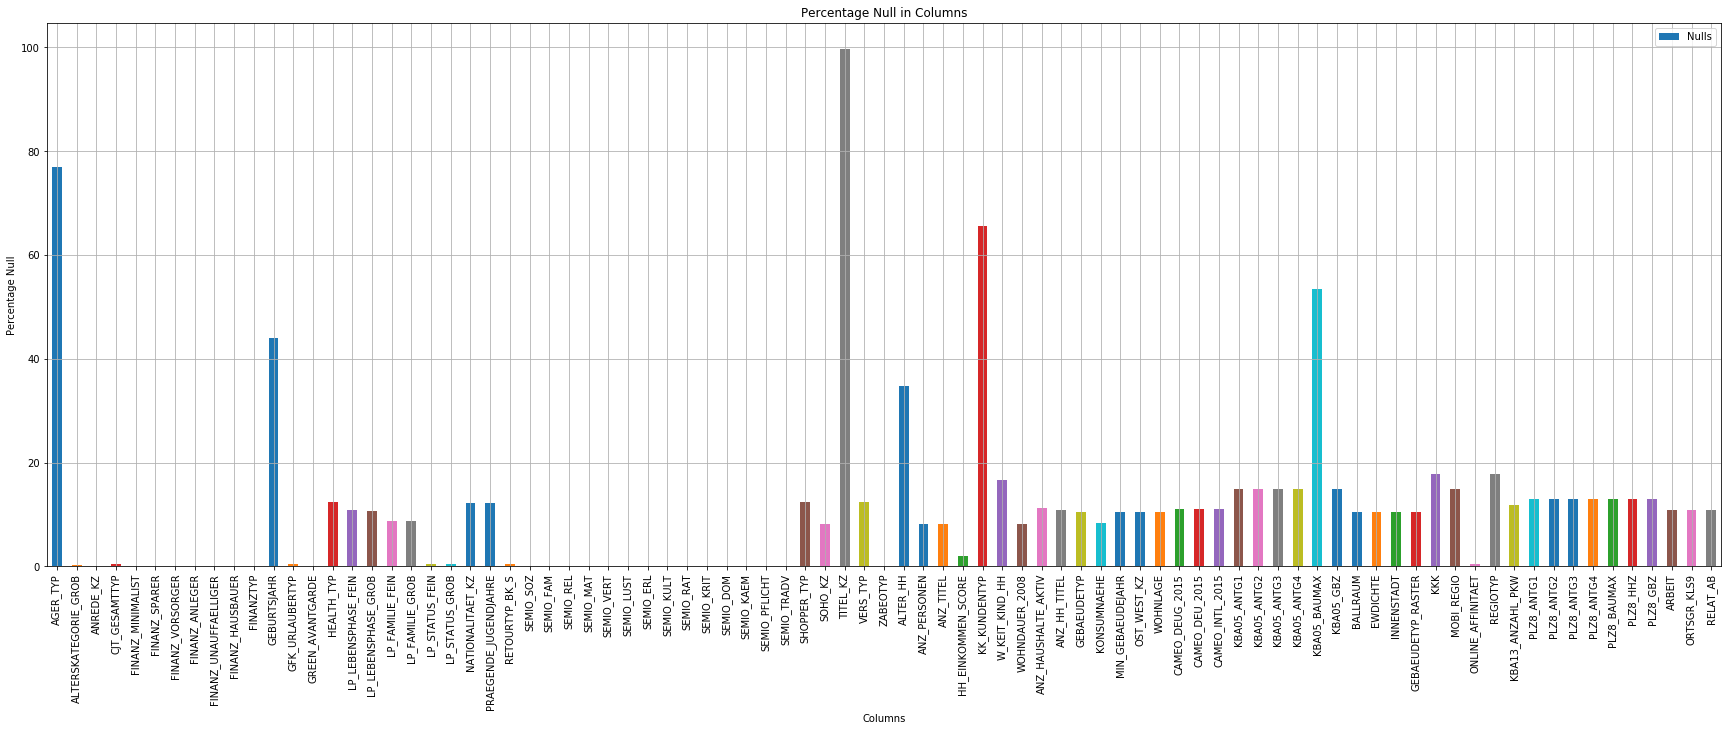

In [21]:
# Plot a bar chart of percentage nulls vs Column names
ax = df_nulls.plot.bar(x='Columns', y='Nulls', figsize = (30,10),rot=90)
plt.xlabel('Columns')
plt.ylabel('Percentage Null')
plt.title('Percentage Null in Columns')
plt.grid(True);

In [22]:
# Make new dataframe where Nulls are over 20%
over20_df = df_nulls[df_nulls['Nulls'] > 20]
over20_df

,Columns,Nulls
0,AGER_TYP,76.955435
11,GEBURTSJAHR,44.020282
40,TITEL_KZ,99.757636
43,ALTER_HH,34.813699
47,KK_KUNDENTYP,65.596749
64,KBA05_BAUMAX,53.468668


In [23]:
over20_df['Columns']

0         AGER_TYP
11     GEBURTSJAHR
40        TITEL_KZ
43        ALTER_HH
47    KK_KUNDENTYP
64    KBA05_BAUMAX
Name: Columns, dtype: object

In [24]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Drop the columns from azdias_copy and feat_info_copy with more than 20 null
for col in over20_df['Columns']:
    azdias_copy.drop(col, axis=1, inplace=True)
    
    for index, row in feat_info_copy.iterrows():
        if(row['attribute']==col):
            feat_info_copy.drop(feat_info_copy[feat_info_copy['attribute']==col].index, inplace=True)    

In [25]:
azdias_copy.shape

(891221, 79)

In [26]:
feat_info_copy.shape

(79, 5)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Since all but 6 columns have less than 20% null, I decided to remove the columns that have more than 20% null rows. AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, and KBA05_BAUMAX have more than 20% null values. All of the columns that are over 20%, except ALTER_HH, are at least 40% null.

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [27]:
# How much data is missing in each row of the dataset?
# number of nulls in each row
null_row_count  = azdias_copy.isnull().sum(axis=1)

In [28]:
# Make dataframe from series null_row_count
df_null_row_count = pd.DataFrame(null_row_count, columns= ['num_null'])
df_null_row_count.head()

,num_null
0,43
1,0
2,0
3,7
4,0


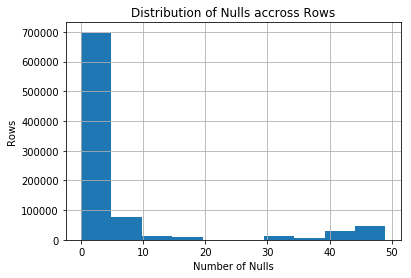

In [29]:
df_null_row_count.num_null.hist();
plt.xlabel('Number of Nulls')
plt.ylabel('Rows')
plt.title('Distribution of Nulls accross Rows');

In [30]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# At least 24 nulls and under 24 nulls
over_24_nulls = df_null_row_count.loc[df_null_row_count['num_null'] >= 24]
under_24_nulls = df_null_row_count.loc[df_null_row_count['num_null'] < 24]

In [31]:
under_24_nulls.head()

,num_null
1,0
2,0
3,7
4,0
5,0


In [32]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Function to take indexes from under or over_24_nulls (at least 24 nulls)
# and returns a dataframe df_sub_cat with subset of azdias_copy with a specified
# column that matches the indexes of the under or over_24_nulls
def sub_cat_function(num_null, col_name):
    sub_cat_array = []

    for index, rows in num_null.iterrows():
        cat_value = azdias_copy[col_name].iloc[index]
        sub_cat_array.append(cat_value)

    df_sub_cat = pd.DataFrame(np.array(sub_cat_array), columns=[col_name])

    return df_sub_cat

In [33]:
# call function for under 24 nulls for ALTERSKATEGORIE_GROB column
df_sub_cat1 = sub_cat_function(under_24_nulls, "ALTERSKATEGORIE_GROB")

list_col_name1 = df_sub_cat1.columns.tolist()

#ax1 = sns.countplot(x=list_col_name1[0], data=df_sub_cat1)

In [34]:
# call function for over 24 nulls for ALTERSKATEGORIE_GROB column
df_sub_cat2 = sub_cat_function(over_24_nulls, "ALTERSKATEGORIE_GROB")

list_col_name2 = df_sub_cat2.columns.tolist()

#ax2 = sns.countplot(x=list_col_name2[0], data=df_sub_cat2)

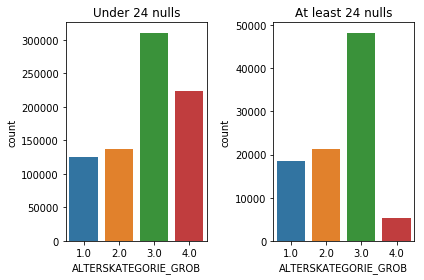

In [35]:
# plot under 24 nulls and at least 24 nulls for ALTERSKATEGORIE_GROB column
# Some of this code is borrowed from 
# https://www.tutorialspoint.com/how-do-i-plot-two-countplot-graphs-side-by-side-in-seaborn-using-matplotlib
fig, ax = plt.subplots(1, 2)
sns.countplot(x=list_col_name1[0], data=df_sub_cat1, ax = ax[0])
sns.countplot(x=list_col_name2[0], data=df_sub_cat2, ax = ax[1])
ax[0].set_title('Under 24 nulls')
ax[1].set_title('At least 24 nulls')
fig.tight_layout()
plt.show()

In [36]:
# call function for under 24 nulls for FINANZ_UNAUFFAELLIGER column
df_sub_cat3 = sub_cat_function(under_24_nulls, "FINANZ_UNAUFFAELLIGER")

list_col_name3 = df_sub_cat3.columns.tolist()

In [37]:
# call function for over 24 nulls for FINANZ_UNAUFFAELLIGER column
df_sub_cat4 = sub_cat_function(over_24_nulls, "FINANZ_UNAUFFAELLIGER")

list_col_name4 = df_sub_cat4.columns.tolist()

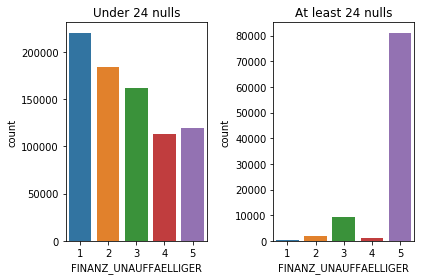

In [38]:
# plot under 24 nulls and at least 24 nulls for FINANZ_UNAUFFAELLIGER column
fig, ax = plt.subplots(1, 2)
sns.countplot(x=list_col_name3[0], data=df_sub_cat3, ax = ax[0])
sns.countplot(x=list_col_name4[0], data=df_sub_cat4, ax = ax[1])
ax[0].set_title('Under 24 nulls')
ax[1].set_title('At least 24 nulls')
fig.tight_layout()
plt.show()

In [39]:
# call function for under 24 nulls for FINANZ_SPARER column
df_sub_cat5 = sub_cat_function(under_24_nulls, "FINANZ_SPARER")

list_col_name5 = df_sub_cat5.columns.tolist()

In [40]:
# call function for over 24 nulls for FINANZ_SPARER column
df_sub_cat6 = sub_cat_function(over_24_nulls, "FINANZ_SPARER")

list_col_name6 = df_sub_cat6.columns.tolist()

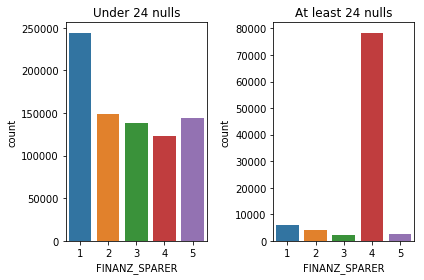

In [41]:
# plot under 24 nulls and at least 24 nulls for FINANZ_SPARER column
fig, ax = plt.subplots(1, 2)
sns.countplot(x=list_col_name5[0], data=df_sub_cat5, ax = ax[0])
sns.countplot(x=list_col_name6[0], data=df_sub_cat6, ax = ax[1])
ax[0].set_title('Under 24 nulls')
ax[1].set_title('At least 24 nulls')
fig.tight_layout()
plt.show()

In [42]:
# call function for under 24 nulls for FINANZ_HAUSBAUER column
df_sub_cat7 = sub_cat_function(under_24_nulls, "FINANZ_HAUSBAUER")

list_col_name7 = df_sub_cat7.columns.tolist()

In [43]:
# call function for over 24 nulls for FINANZ_HAUSBAUER column
df_sub_cat8 = sub_cat_function(over_24_nulls, "FINANZ_HAUSBAUER")

list_col_name8 = df_sub_cat8.columns.tolist()

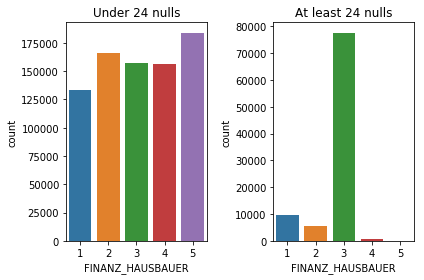

In [44]:
# plot under 24 nulls and at least 24 nulls for FINANZ_HAUSBAUER column
fig, ax = plt.subplots(1, 2)
sns.countplot(x=list_col_name7[0], data=df_sub_cat7, ax = ax[0])
sns.countplot(x=list_col_name8[0], data=df_sub_cat8, ax = ax[1])
ax[0].set_title('Under 24 nulls')
ax[1].set_title('At least 24 nulls')
fig.tight_layout()
plt.show()

In [45]:
# call function for under 24 nulls for CJT_GESAMTTYP column
df_sub_cat9 = sub_cat_function(under_24_nulls, "CJT_GESAMTTYP")

list_col_name9 = df_sub_cat9.columns.tolist()

In [46]:
# call function for over 24 nulls for CJT_GESAMTTYP column
df_sub_cat10 = sub_cat_function(over_24_nulls, "CJT_GESAMTTYP")

list_col_name10 = df_sub_cat10.columns.tolist()

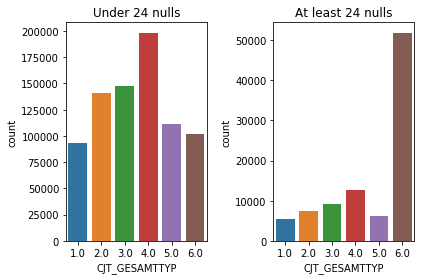

In [47]:
# plot under 24 nulls and at least 24 nulls for CJT_GESAMTTYP column
fig, ax = plt.subplots(1, 2)
sns.countplot(x=list_col_name9[0], data=df_sub_cat9, ax = ax[0])
sns.countplot(x=list_col_name10[0], data=df_sub_cat10, ax = ax[1])
ax[0].set_title('Under 24 nulls')
ax[1].set_title('At least 24 nulls')
fig.tight_layout()
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

There are some differences in the data in the "Under 44 nulls" chart and the "At least 44 nulls" chart. For the columns in the "Under 44 nulls" chart all values, while not equal, have a healthy representation. 

In most of the "At least 44 nulls" charts, one value is highly overrepresented and the other values are almost not represented at all. For example, in the "FINANZ_UNAUFFAELLIGER" column, the value "5" has more than 40,000 count and the other values are not represented. In the FINANZ_SPARER chart, the value "4" is overrepresented, a value of more than 40,000,  and the other values are not represented. In the "FINANZ_HAUSBAUER" chart, the value "3" is overrepresented, a value of more than 40,000, and the other values are not represented. In the "CJT_GESAMTTYP" chart, the value "6.0" is overrepresented, a value of more than 40,000, "5.0" is underrepresented, and the other values are not represented.

Values in "ALTERSKATEGORIE_GROB" column are proportioned a little differently in the "Under 44 nulls" than the "Over 44 nulls" chart. In the "Under 44 nulls" chart, the "4.0" value is not represented, and the 1.0 and 2.0 values are underrepresented.

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [48]:
# How many features are there of each data type?
feat_info_copy['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [49]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Make new df_feat_copy_categ from categorical variables in feat_info_copy
df_feat_copy_categ = feat_info_copy[feat_info_copy['type'] == 'categorical']
df_feat_copy_categ

,attribute,information_level,type,missing_or_unknown,NA_tags
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
10,FINANZTYP,person,categorical,[-1],[-1]
12,GFK_URLAUBERTYP,person,categorical,[],[]
13,GREEN_AVANTGARDE,person,categorical,[],[]
17,LP_FAMILIE_FEIN,person,categorical,[0],[0]
18,LP_FAMILIE_GROB,person,categorical,[0],[0]
19,LP_STATUS_FEIN,person,categorical,[0],[0]
20,LP_STATUS_GROB,person,categorical,[0],[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]","[-1, 0]"


In [50]:
#Find the non-numerical columns in azdias_copy
azdias_copy.select_dtypes(exclude=np.number)

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015
0,NaN,NaN,NaN,NaN
1,W,8,8A,51
2,W,4,4C,24
3,W,2,2A,12
4,W,6,6B,43
5,W,8,8C,54
6,W,4,4A,22
7,W,2,2D,14
8,W,1,1A,13
9,W,1,1E,15


In [51]:
# Categorical and multilevel
azdias_copy['CAMEO_DEUG_2015'].unique()

array([nan, '8', '4', '2', '6', '1', '9', '5', '7', '3'], dtype=object)

In [52]:
# Categorical and multilevel
azdias_copy['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

In [53]:
# Categorical and multilevel
azdias_copy['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [54]:
# OST_WEST_KZ is binary, categorical, and non-numeric, has 'W' and 'O' as values
azdias_copy['OST_WEST_KZ'].unique()

array([nan, 'W', 'O'], dtype=object)

In [55]:
# binary, 2 unique variables
azdias_copy['OST_WEST_KZ'].nunique()

2

In [56]:
# Create dummy variables. 
# Code borrowed from 
# https://www.geeksforgeeks.org/how-to-convert-categorical-variable-to-numeric-in-pandas/

# get the dummies and store it in a variable
dummies = pd.get_dummies(azdias_copy.OST_WEST_KZ)
 
# Concatenate the dummies to original dataframe
azdias_copy = pd.concat([azdias_copy, dummies], axis='columns')
 
# drop the values
azdias_copy.drop(['OST_WEST_KZ'], axis='columns', inplace=True)
df_feat_copy_categ.drop(df_feat_copy_categ[df_feat_copy_categ['attribute']=='OST_WEST_KZ'].index, inplace=True)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [57]:
# Confirm 'W' and 'O' added and 'OZ_WEST_KZ' dropped
list(azdias_copy.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'GEBAEUDETYP',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'WOHNLAGE',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'K

In [58]:
# Re-encode categorical variable(s) to be kept in the analysis.
# iterate through feat_info_copy['attribute'] column
# get number of unique values for the corresponding column in azdias_copy
# if azdias_copy[df_feat_copy_column].nunique()>= 3 ,drop column

for cat in df_feat_copy_categ['attribute']:
    if (azdias_copy[cat].nunique()>= 3):
        print("Column dropped:", cat)
        azdias_copy.drop(cat, axis=1, inplace=True)

Column dropped: CJT_GESAMTTYP
Column dropped: FINANZTYP
Column dropped: GFK_URLAUBERTYP
Column dropped: LP_FAMILIE_FEIN
Column dropped: LP_FAMILIE_GROB
Column dropped: LP_STATUS_FEIN
Column dropped: LP_STATUS_GROB
Column dropped: NATIONALITAET_KZ
Column dropped: SHOPPER_TYP
Column dropped: ZABEOTYP
Column dropped: GEBAEUDETYP
Column dropped: CAMEO_DEUG_2015
Column dropped: CAMEO_DEU_2015


In [59]:
# Confirm dropped columns
list(azdias_copy.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PL

#### Discussion 1.2.1: Re-Encode Categorical Features

To re-encode columns in azdias_copy, we need to transform binary categories that are not numeric into numeric binary variables and drop any columns that have 3 or more unique value.

The column 'OST_WEST_KZ' is both categorical and non-numeric. It has 'W' and 'O' as values, so I created dummy variables for this column. The result of this is 2 new columns, 'W' and 'O', that have the numeric binary values of 1 and 0. The column 'OST_WEST_KZ' is dropped from the azdias_copy.

The columns, 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP,' 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015,' 'CAMEO_DEU_2015' have 3 or more values. Those columns are dropped from the azdais_copy.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [60]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Datatype is float
azdias_copy['PRAEGENDE_JUGENDJAHRE']

0          NaN
1         14.0
2         15.0
3          8.0
4          8.0
5          3.0
6         10.0
7          8.0
8         11.0
9         15.0
10         3.0
11         NaN
12         8.0
13        15.0
14         NaN
15         5.0
16        14.0
17         NaN
18        10.0
19         9.0
20        11.0
21        10.0
22        14.0
23         9.0
24         NaN
25        14.0
26         8.0
27        11.0
28        10.0
29         6.0
          ... 
891191     3.0
891192    14.0
891193     5.0
891194    11.0
891195     8.0
891196    14.0
891197    11.0
891198    15.0
891199    10.0
891200    14.0
891201    10.0
891202    10.0
891203     NaN
891204    10.0
891205     3.0
891206    14.0
891207     2.0
891208     8.0
891209    14.0
891210     8.0
891211     8.0
891212     3.0
891213    11.0
891214    14.0
891215    10.0
891216    14.0
891217    10.0
891218    14.0
891219    14.0
891220     3.0
Name: PRAEGENDE_JUGENDJAHRE, Length: 891221, dtype: float64

In [61]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# decade: interval variable 

# create column decade and map the decade variables with the data dictionary
azdias_copy['DECADE']= azdias_copy['PRAEGENDE_JUGENDJAHRE'].map(
                 {-1.0: 'unknown', 0.0: 'unknown', 
                  1.0: 40, 2.0: 40, 
                  3.0: 50, 4.0: 50, 
                  5.0: 60, 6.0: 60, 7.0: 60,
                  8.0: 70, 9.0: 70,
                  10.0: 80, 11.0: 80, 12.0: 80, 13.0: 80,
                  14.0: 90, 15.0: 90}, 
                  na_action='ignore')

In [62]:
# movement: binary variable
# create column decade and map the decade variables with the data dictionary
azdias_copy['MOVEMENT']= azdias_copy['PRAEGENDE_JUGENDJAHRE'].map(
                 {-1.0: np.nan, 0.0: np.nan,
                  1.0:0, 2.0:1, 
                  3.0:0, 4.0:1, 
                  5.0:0, 6.0:1, 
                  7.0:1, 8.0: 0, 
                  9.0:1, 10.0:0,
                  11.0:1, 12.0:0, 
                  13.0:1, 14.0:0,
                  15.0:1},
                  na_action='ignore')

In [63]:
# Drop 'PRAEGENDE_JUGENDJAHRE'
azdias_copy.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [64]:
list(azdias_copy.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',

In [65]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables:
# 'WEALTH' and LIFE_STAGE.
# Datatype is object
azdias_copy['CAMEO_INTL_2015']

0         NaN
1          51
2          24
3          12
4          43
5          54
6          22
7          14
8          13
9          15
10         51
11        NaN
12         43
13         33
14        NaN
15         41
16         41
17        NaN
18         24
19         34
20         24
21         55
22         51
23         43
24        NaN
25         33
26        NaN
27         51
28         13
29         12
         ... 
891191     44
891192     32
891193     43
891194     24
891195     55
891196     23
891197     24
891198     14
891199     51
891200     52
891201     41
891202     41
891203     25
891204     24
891205     34
891206     25
891207     41
891208     14
891209     51
891210     41
891211     51
891212     51
891213     34
891214     23
891215     31
891216     41
891217     51
891218     24
891219     51
891220     43
Name: CAMEO_INTL_2015, Length: 891221, dtype: object

In [66]:
# The unique values of 'CAMEO_INTL_2015'
azdias_copy['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [67]:
# Split string into 10's and 1's place
# Store 10's character as 'WEALTH'
azdias_copy['WEALTH']= azdias_copy['CAMEO_INTL_2015'].map(
                 {'51':5, '24':2, '12':1, '43':4, '54':5, 
                  '22':2, '14':1, '13':1, '15':1, '33':3, 
                  '41':4, '34':3, '55':5, '25':2, '23':2, 
                  '31':3, '52':5, '35':3, '45':4, '44':4, 
                  '32':3}, na_action='ignore')

In [68]:
# Split string into 10's and 1's place
# Store 1's character as 'LIFE_STAGE'
azdias_copy['LIFE_STAGE']= azdias_copy['CAMEO_INTL_2015'].map(
                 {'51':1, '24':4, '12':2, '43':3, '54':4, 
                  '22':2, '14':4, '13':3, '15':5, '33':3, 
                  '41':1, '34':4, '55':5, '25':5, '23':3, 
                  '31':1, '52':2, '35':5, '45':5, '44':4, 
                  '32':2}, na_action='ignore')

In [69]:
# Drop 'CAMEO_INTL_2015'
azdias_copy.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [70]:
list(azdias_copy.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'WOHNLAGE',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_HHZ',
 'PLZ8

#### Discussion 1.2.2: Engineer Mixed-Type Features

For this section 'PRAEGENDE_JUGENDJAHRE' was split into two variables, 'DECADE' and 'MOVEMENT.' Data_Dictionary.md was used as a reference to assign values from a single value representing both 'DECADE' and 'MOVEMENT.' The new values for 'DECADE' are 40, 50, 60, 70, 80, and 90. To 'MOVEMENT,' the values 0 for 'Mainstream' or 1 for 'Avantguarde' are assigned. The new variables are assigned using the pandas map function. The column, 'PRAEGENDE_JUGENDJAHRE,' is dropped.

'CAMEO_INTL_2015' was split into 2 variables, 'WEALTH' and 'LIFE_STAGE.' The column, 'CAMEO_INTL_2015' contains a string, with the 10's place representing 'WEALTH' and the 1's place representing 'LIFE_STAGE.' After determining the unique values of 'CAMEO_INTL_2015,' assignments are made to the new columns using the map function. Afterwards, the 'CAMEO_INTL_2015' is dropped.


(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [71]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Make new df's for subset
# azdias_copy= under 24 nulls
# azdias_copy_over24 = at least 24 nulls
azdias_copy_over24 = azdias_copy[azdias_copy.isnull().sum(axis=1) >= 24]
azdias_copy = azdias_copy[azdias_copy.isnull().sum(axis=1) < 24]

In [72]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [73]:
def clean_data(df, clean_feat_info_copy):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # Number naturally null
    print(df.isna().sum().sum())
    # Apply function string_to_list to create a new column, 'NA_tags,' for feat_info_copy
    clean_feat_info_copy['NA_tags'] = clean_feat_info_copy['missing_or_unknown'].apply(string_to_list)                                                                       

    # Sets the index of feat_info_copy to 'attribute'
    #clean_feat_info_copy = clean_feat_info_copy.set_index('attribute')
    
    
    # remove selected columns and rows, ...
    # Iterate through each column in azdias_copy
    # Where the value is equal to a value in 'NA_tags' in feat_info_copy,
    # replace them with np.nan
    for column in df.columns:
        df[column].replace(clean_feat_info_copy.loc[column].loc['NA_tags'],np.NaN,inplace=True)

    # Null after NaN replacements
    print(df.isna().sum().sum())
    
    # Reset index of feat_info_copy to original index
    clean_feat_info_copy = clean_feat_info_copy.reset_index()
    clean_feat_info_copy.head()

    # remove selected columns and rows, ...

    # Remove the outlier columns from the dataset. (You'll perform other data
    # engineering tasks such as re-encoding and imputation later.)
    # Drop the columns from azdias_copy and feat_info_copy with more than 20 null
    for col in over20_df['Columns']:
        df.drop(col, axis=1, inplace=True)
    
    # Create dummy variables. 
    # Code borrowed from 
    # https://www.geeksforgeeks.org/how-to-convert-categorical-variable-to-numeric-in-pandas/

    # get the dummies and store it in a variable
    dummies = pd.get_dummies(df.OST_WEST_KZ)
 
    # Concatenate the dummies to original dataframe
    df = pd.concat([df, dummies], axis='columns')
 
    # drop the values
    df.drop(['OST_WEST_KZ'], axis='columns', inplace=True)
    df_feat_copy_categ.drop(df_feat_copy_categ[df_feat_copy_categ['attribute']=='OST_WEST_KZ'].index, inplace=True)
                
    # Re-encode categorical variable(s) to be kept in the analysis.
    # iterate through feat_info_copy['attribute'] column
    # get number of unique values for the corresponding column in azdias_copy
    # if azdias_copy[df_feat_copy_column].nunique()>= 3 ,drop column

    for cat in df_feat_copy_categ['attribute']:
        if (df[cat].nunique()>= 3):
            df.drop(cat, axis=1, inplace=True)
            
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # decade: interval variable 

    # create column decade and map the decade variables with the data dictionary
    df['DECADE']= df['PRAEGENDE_JUGENDJAHRE'].map(
                     {-1.0: 'unknown', 0.0: 'unknown', 
                      1.0: 40, 2.0: 40, 
                      3.0: 50, 4.0: 50, 
                      5.0: 60, 6.0: 60, 7.0: 60,
                      8.0: 70, 9.0: 70,
                      10.0: 80, 11.0: 80, 12.0: 80, 13.0: 80,
                      14.0: 90, 15.0: 90}, 
                      na_action='ignore')
    
    # movement: binary variable
    # create column decade and map the decade variables with the data dictionary
    df['MOVEMENT']= df['PRAEGENDE_JUGENDJAHRE'].map(
                     {-1.0: np.nan, 0.0: np.nan,
                      1.0:0, 2.0:1, 
                      3.0:0, 4.0:1, 
                      5.0:0, 6.0:1, 
                      7.0:1, 8.0:0, 
                      9.0:1, 10.0:0,
                      11.0:1, 12.0:0, 
                      13.0:1, 14.0:0,
                      15.0:1},
                      na_action='ignore')
    
    # Drop 'PRAEGENDE_JUGENDJAHRE'
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # Split string into 10's and 1's place
    # Store 10's character as 'WEALTH'
    df['WEALTH']= df['CAMEO_INTL_2015'].map(
                     {'51':5, '24':2, '12':1, '43':4, '54':5, 
                      '22':2, '14':1, '13':1, '15':1, '33':3, 
                      '41':4, '34':3, '55':5, '25':2, '23':2, 
                      '31':3, '52':5, '35':3, '45':4, '44':4, 
                      '32':3}, na_action='ignore')
    
    # Split string into 10's and 1's place
    # Store 1's character as 'LIFE_STAGE'
    df['LIFE_STAGE']= df['CAMEO_INTL_2015'].map(
                     {'51':1, '24':4, '12':2, '43':3, '54':4, 
                      '22':2, '14':4, '13':3, '15':5, '33':3, 
                      '41':1, '34':4, '55':5, '25':5, '23':3, 
                      '31':1, '52':2, '35':5, '45':5, '44':4, 
                      '32':2}, na_action='ignore')
    
    # Drop 'CAMEO_INTL_2015'
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)

    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [74]:
azdias_copy.isna().sum().sum()

883302

In [75]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Remove all rows with null values using imputer
# Code based on code by mentor Rajat

from sklearn.preprocessing import Imputer

azdias_copy_test = azdias_copy.astype(float)
imputer = Imputer(strategy='mean') 
azdias_test_imput_df = pd.DataFrame(imputer.fit_transform(azdias_copy_test),columns=azdias_copy_test.columns)


In [76]:
# Confirm all nulls replaced
azdias_test_imput_df.isna().sum().sum()

0

In [77]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

scale = StandardScaler(with_mean=0, with_std=1)
X = scale.fit_transform(azdias_test_imput_df)

#Dataset
X

array([[ 0.98363663,  4.00369405,  0.72591756, ...,  0.        ,
         3.42740552,  0.6761197 ],
       [ 2.95090989,  4.00369405,  0.72591756, ...,  2.42849302,
         1.37096221,  2.7044788 ],
       [ 3.93454652,  4.00369405,  2.90367025, ...,  0.        ,
         0.6854811 ,  1.3522394 ],
       ..., 
       [ 1.96727326,  4.00369405,  1.45183512, ...,  0.        ,
         1.37096221,  2.7044788 ],
       [ 0.98363663,  2.00184702,  0.72591756, ...,  0.        ,
         3.42740552,  0.6761197 ],
       [ 3.93454652,  2.00184702,  2.90367025, ...,  0.        ,
         2.74192442,  2.0283591 ]])

### Discussion 2.1: Apply Feature Scaling

I decided to use an Imputer to replace the null values with a mean value because although there were a number of single nulls, each row and each column still contained a lot of useful data, and I wanted to preserve the sample size.

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [78]:
from sklearn.decomposition import PCA

# Function pca_results from Udacity nanodegree course materials
# with a couple of small changes
def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (50,30))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=90)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)



In [79]:
azdias_test_imput_df.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,O,W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
count,798025.000000,798025.000000,798025.000000,798025.000000,798025.000000,798025.000000,798025.000000,798025.000000,798025.000000,798025.000000,...,798025.000000,798025.000000,798025.000000,798025.000000,798025.000000,798025.000000,798025.000000,798025.000000,798025.000000,798025.000000
mean,2.795397,1.521474,3.058953,2.715985,3.432901,2.840877,2.658258,3.114139,0.219573,2.199020,...,3.381087,3.166702,5.293413,3.071048,0.211193,0.788807,73.320105,0.227770,3.262106,2.873034
std,1.016636,0.499539,1.377568,1.485068,1.376892,1.472746,1.399484,1.408108,0.413958,0.737605,...,1.095236,0.996419,2.297393,1.356922,0.408155,0.408155,14.309493,0.411778,1.458830,1.479029
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,40.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,3.000000,3.000000,4.000000,2.000000,0.000000,1.000000,60.000000,0.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,3.000000,3.000000,5.000000,3.000000,0.000000,1.000000,73.320105,0.000000,4.000000,3.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,4.000000,4.000000,7.000000,4.000000,0.000000,1.000000,90.000000,0.227770,5.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,5.000000,5.000000,9.000000,5.000000,1.000000,1.000000,90.000000,1.000000,5.000000,5.000000


In [80]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X)
X_pca

array([[  3.15327647e+00,  -3.15414474e+00,  -2.98231062e+00, ...,
          1.68842609e-01,  -2.43404283e-02,  -3.58700079e-15],
       [ -6.74972827e-01,   3.87060655e-01,  -3.07800365e+00, ...,
         -5.22981706e-02,   1.25765661e-02,   4.54386442e-15],
       [ -3.83966653e+00,   1.65178666e+00,  -7.48822817e-01, ...,
         -5.04940275e-02,  -9.98220259e-03,   1.38899597e-16],
       ..., 
       [ -1.49796127e+00,  -3.31504173e+00,  -2.96348895e+00, ...,
          2.93048389e-02,  -2.00083796e-02,  -3.26958843e-16],
       [  5.36799385e+00,  -3.97634732e+00,   2.31743782e+00, ...,
          2.12415350e-02,  -4.81987812e-02,  -4.04206416e-16],
       [ -4.64656079e-01,   1.19422856e+00,   3.02634902e+00, ...,
         -5.86516430e-02,   4.29701426e-03,  -5.90528173e-16]])

In [81]:
X.shape

(798025, 69)

In [82]:
X_pca.shape

(798025, 69)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,O,W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
Dimension 1,0.1705,-0.0859,0.0106,-0.1987,0.1130,-0.0851,0.0420,0.0452,0.1647,-0.1032,...,-0.1682,0.1434,0.1966,0.1330,0.0596,-0.0596,0.0692,-0.1010,0.2015,-0.1173
Dimension 2,0.1259,0.2726,0.0845,0.0960,-0.2528,0.2448,-0.2130,-0.2351,0.0942,0.0011,...,-0.0490,0.0487,0.0644,0.0461,0.0207,-0.0207,-0.2620,0.0028,0.0451,0.0192
Dimension 3,0.0881,0.0772,-0.3693,0.1612,-0.1060,0.0988,-0.1873,-0.0980,-0.0488,0.0531,...,-0.0352,0.0318,0.0420,0.0275,0.0172,-0.0172,-0.1054,0.0511,0.0198,-0.0048
Dimension 4,0.0554,-0.0368,0.0348,0.0585,0.0012,-0.0059,-0.1074,0.0778,-0.1062,0.3476,...,0.0148,0.0568,0.2477,0.1078,-0.1324,0.1324,0.0399,0.3472,-0.0963,0.0398
Dimension 5,0.0427,0.0196,0.0131,0.0527,-0.0061,-0.0667,0.0872,-0.0979,-0.0176,-0.0301,...,-0.2828,0.1727,0.0106,0.0475,0.3450,-0.3450,0.0206,-0.0330,0.0332,0.0095
Dimension 6,0.0337,0.0449,-0.0268,-0.0373,0.0174,0.0904,0.0236,0.0147,-0.0150,-0.1742,...,0.1430,-0.1338,-0.0416,-0.0176,-0.2810,0.2810,0.0045,-0.1725,0.1264,-0.1328
Dimension 7,0.0309,0.0124,0.0212,-0.0467,0.0029,-0.0357,0.0219,-0.0306,0.0733,0.0158,...,0.1198,-0.1834,-0.1127,-0.2451,0.1709,-0.1709,0.0044,0.0191,-0.0543,0.0458
Dimension 8,0.0273,-0.0276,-0.0125,0.0260,0.0117,0.0486,-0.0385,0.0633,-0.1165,0.0011,...,-0.2164,-0.1838,0.0404,-0.0443,-0.3034,0.3034,0.0249,0.0032,-0.0430,-0.0380
Dimension 9,0.0240,0.0282,0.0526,-0.0382,-0.0423,0.0807,-0.0893,0.0159,0.0741,-0.0246,...,-0.2249,-0.2287,-0.1537,-0.0725,-0.1941,0.1941,-0.0683,-0.0214,0.0486,-0.0740
Dimension 10,0.0223,-0.1078,0.0924,0.0502,-0.1618,0.1615,-0.1042,-0.1769,0.1302,-0.0446,...,0.0997,0.1459,0.0867,0.0792,0.0354,-0.0354,-0.2079,-0.0419,-0.0113,0.0977


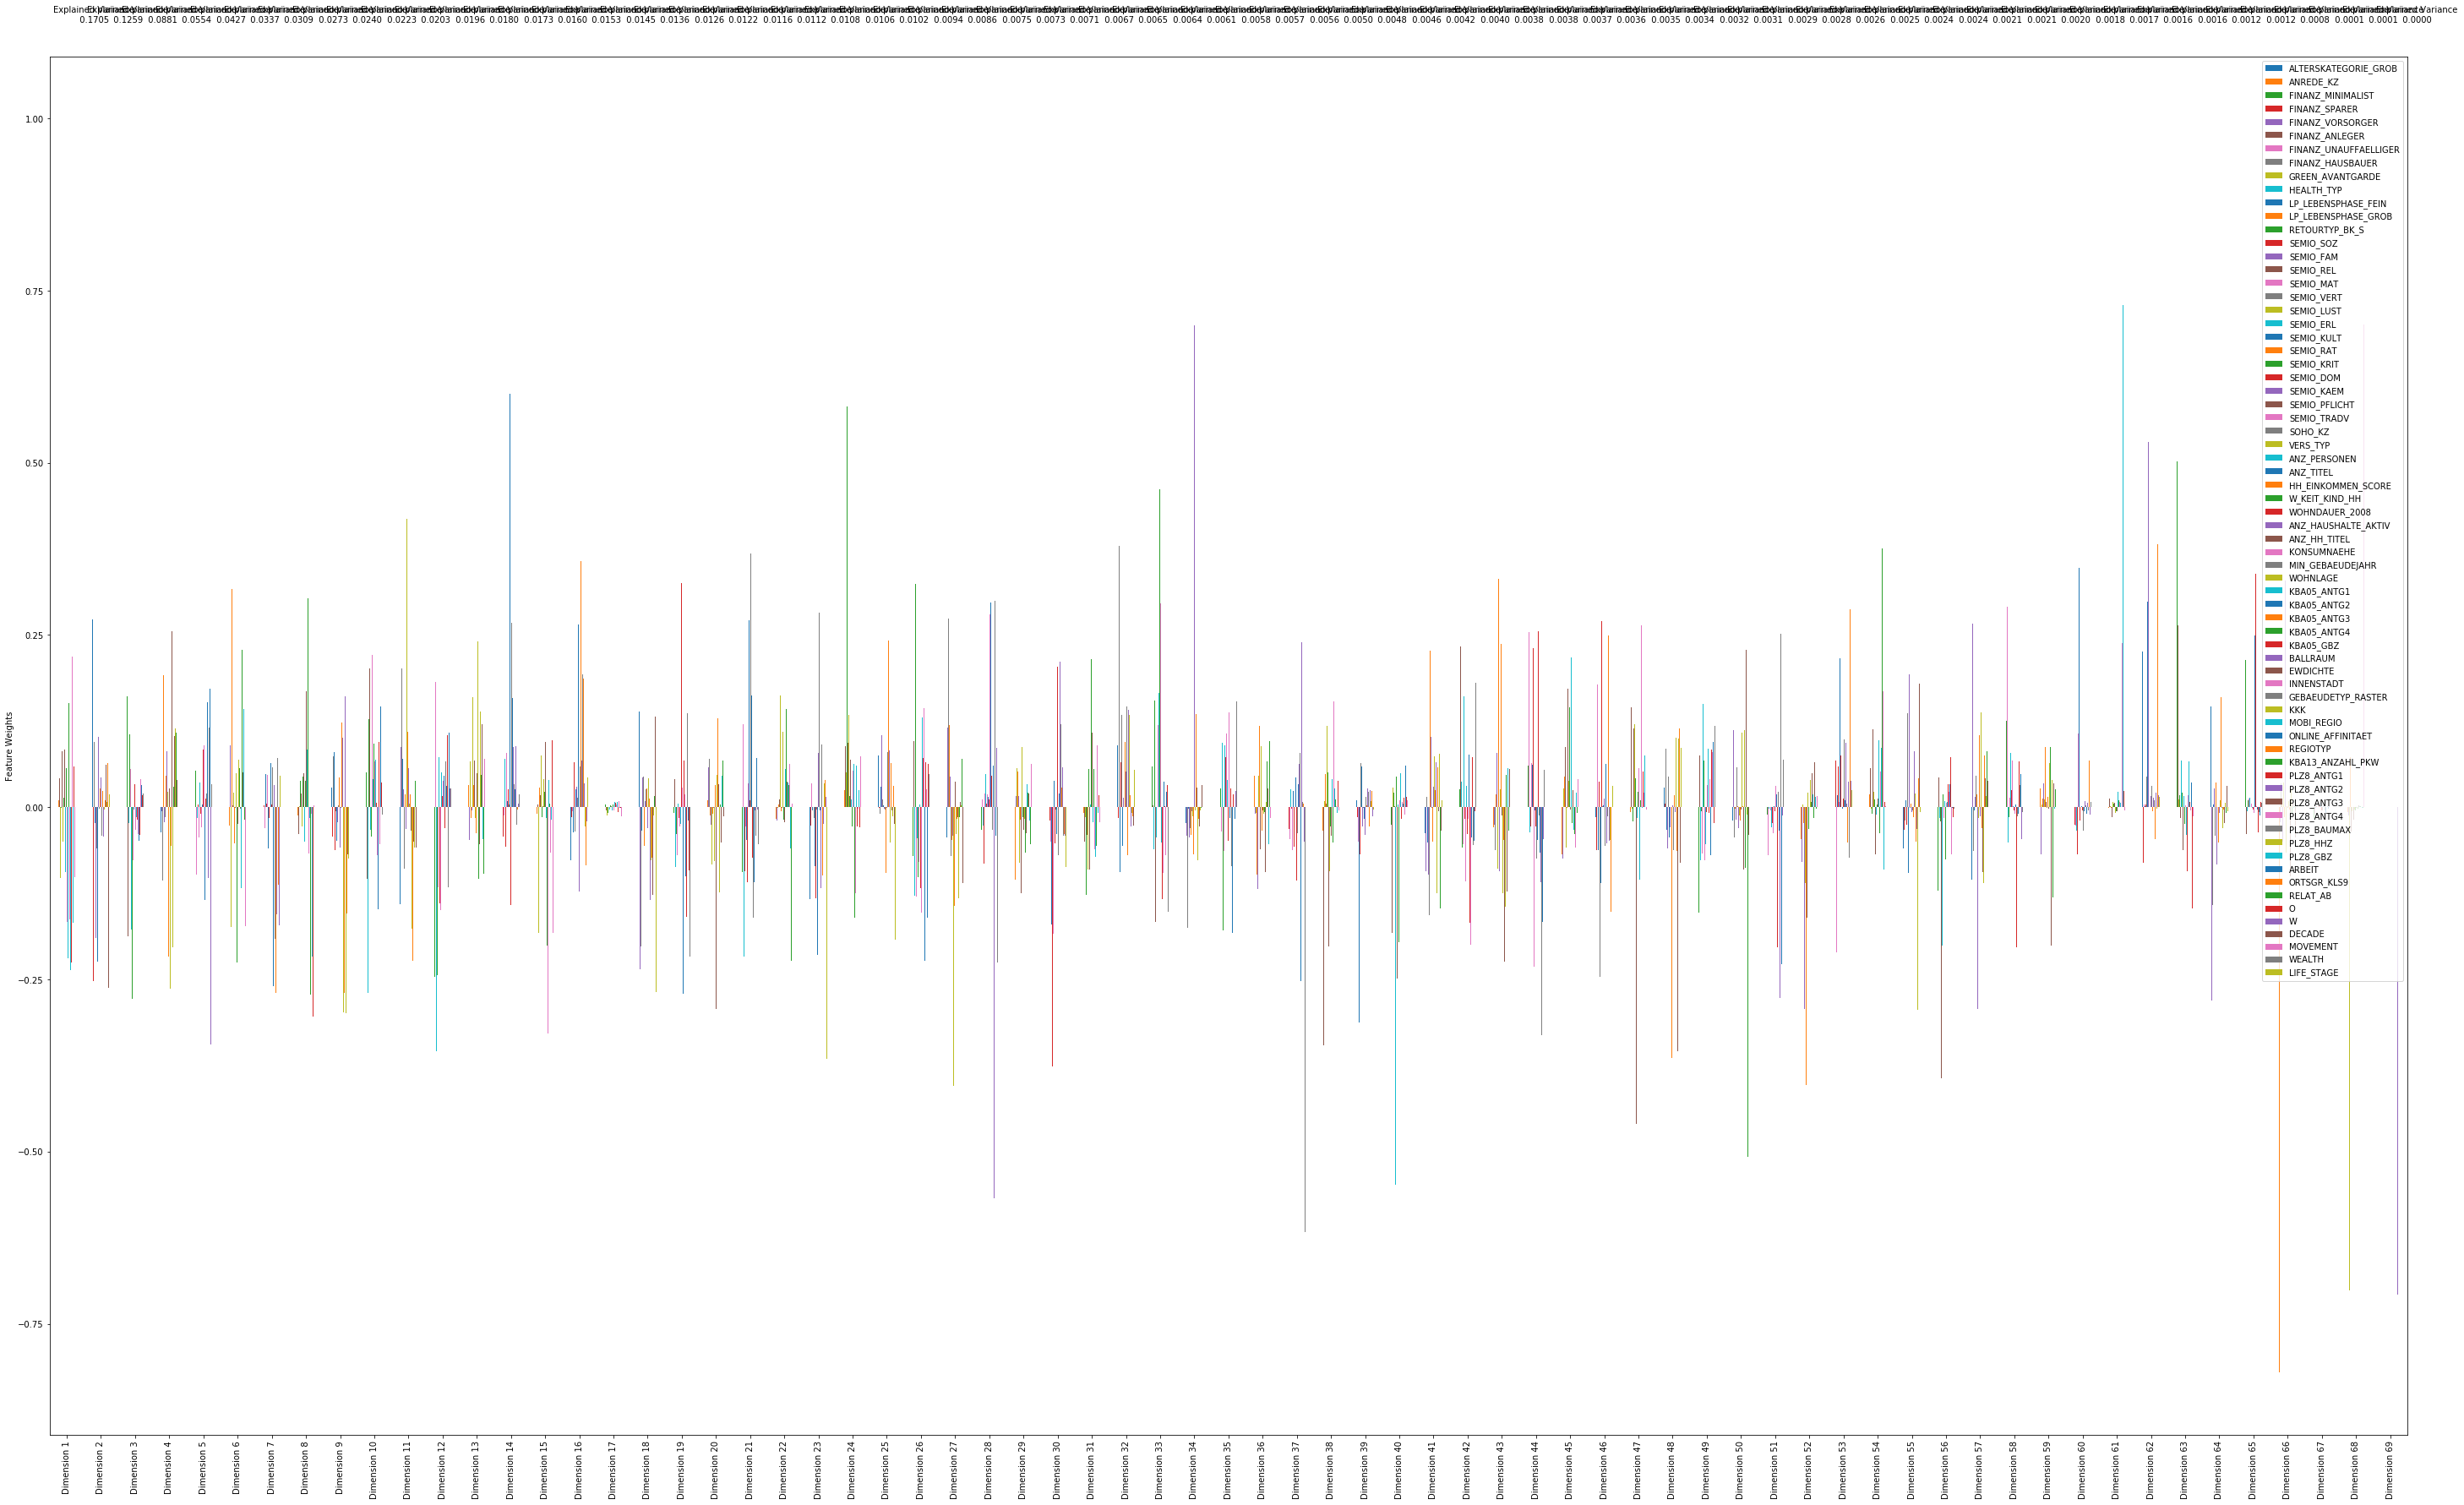

In [83]:
# Investigate the variance accounted for by each principal component.

pca_results_df = pca_results(azdias_test_imput_df, pca)
pca_results_df

In [84]:
"""# Method to find more than .85% of explained variance is from 
# Udacity unsupervised learning material
for comp in range(1, azdias_test_imput_df.shape[1]):
    pca = PCA(n_components=comp)
    X_pca = pca.fit_transform(X)
    #pca, X_pca = do_pca(comp, azdias_test_imput_df)
    comp_check = pca_results(azdias_test_imput_df, pca)
    if comp_check['Explained Variance'].sum() > 0.85:
        break
        

num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(comp_check.shape[0],comp_check['Explained Variance'].sum()*100))"""

'# Method to find more than .85% of explained variance is from \n# Udacity unsupervised learning material\nfor comp in range(1, azdias_test_imput_df.shape[1]):\n    pca = PCA(n_components=comp)\n    X_pca = pca.fit_transform(X)\n    #pca, X_pca = do_pca(comp, azdias_test_imput_df)\n    comp_check = pca_results(azdias_test_imput_df, pca)\n    if comp_check[\'Explained Variance\'].sum() > 0.85:\n        break\n        \n\nnum_comps = comp_check.shape[0]\nprint("Using {} components, we can explain {}% of the variability in the original data.".format(comp_check.shape[0],comp_check[\'Explained Variance\'].sum()*100))'

In [85]:
# Re-apply PCA to the data while selecting for number of components to retain.
# 27 components needed to find more than 85% of explained variance
pca = PCA(n_components=27)
X_pca = pca.fit_transform(X)
X_pca

array([[ 3.15327602, -3.15414068, -2.9823049 , ..., -0.05156601,
         0.23306535,  0.23572266],
       [-0.67497236,  0.38705995, -3.07800216, ..., -1.25750019,
        -0.11561125,  0.31893173],
       [-3.83966684,  1.65178848, -0.7488198 , ..., -0.77506989,
        -0.81487989,  0.48395177],
       ..., 
       [-1.49796089, -3.31504141, -2.96349375, ..., -1.64748703,
        -0.41166717, -0.85251466],
       [ 5.36799414, -3.97634596,  2.31743167, ..., -0.5096487 ,
         0.19035586, -0.89048283],
       [-0.46465637,  1.19422878,  3.02635375, ..., -0.47956929,
        -0.16108844,  0.59966467]])

### Discussion 2.2: Perform Dimensionality Reduction

The amount of variability explained by the first two components are each greater than .1: the first component is 0.1705 and the second component is 0.1259. The first four components have a combined explained variability of .4826, or over 48.26% of the explained variability.

I decided to retain 27 principal components/transformed features needed to find more than 85% of explained variance.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [86]:
# Function to map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

from operator import itemgetter

def weight_order(dimension, data):
    """
    Creates a dictionary of a single dimension, 
    mapping column name to explained variance for the column.
    
    Stores the dictionary as a tuple.
    
    Sorts the tuple by weight.
    Prints a tuple of a column name and corresponding weight.
    """
    weights_dict = {}
    col_names = list(data.columns)

    for name in col_names:
        weights_dict.update({name: data.at[dimension, name]})

    weights_tuple = weights_dict.items()

    # put in order sorted by weight
    #https://docs.python.org/2/library/operator.html#operator.itemgetter
    getorder = itemgetter(1)
    map(getorder, weights_tuple)
    print(list(sorted(weights_tuple, key=getorder,reverse=True)))

In [87]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_order('Dimension 1', pca_results_df)

[('PLZ8_ANTG3', 0.22470000000000001), ('PLZ8_ANTG4', 0.21929999999999999), ('PLZ8_BAUMAX', 0.215), ('WEALTH', 0.20150000000000001), ('HH_EINKOMMEN_SCORE', 0.19700000000000001), ('ORTSGR_KLS9', 0.1966), ('EWDICHTE', 0.19370000000000001), ('Explained Variance', 0.17050000000000001), ('FINANZ_HAUSBAUER', 0.16470000000000001), ('PLZ8_ANTG2', 0.1512), ('KBA05_ANTG4', 0.15079999999999999), ('ARBEIT', 0.1434), ('ANZ_HAUSHALTE_AKTIV', 0.1341), ('RELAT_AB', 0.13300000000000001), ('KBA05_ANTG3', 0.13089999999999999), ('FINANZ_SPARER', 0.113), ('SEMIO_PFLICHT', 0.084099999999999994), ('SEMIO_REL', 0.081299999999999997), ('DECADE', 0.069199999999999998), ('SEMIO_RAT', 0.0688), ('REGIOTYP', 0.067599999999999993), ('SEMIO_TRADV', 0.060100000000000001), ('O', 0.0596), ('SEMIO_FAM', 0.058599999999999999), ('SEMIO_MAT', 0.058599999999999999), ('W_KEIT_KIND_HH', 0.057000000000000002), ('SEMIO_KULT', 0.049500000000000002), ('FINANZ_UNAUFFAELLIGER', 0.045199999999999997), ('SEMIO_KAEM', 0.0430999999999999

In [88]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weight_order('Dimension 2', pca_results_df)

[('ALTERSKATEGORIE_GROB', 0.27260000000000001), ('FINANZ_VORSORGER', 0.24479999999999999), ('SEMIO_ERL', 0.2354), ('SEMIO_LUST', 0.19089999999999999), ('RETOURTYP_BK_S', 0.16439999999999999), ('Explained Variance', 0.12590000000000001), ('W_KEIT_KIND_HH', 0.1167), ('SEMIO_KRIT', 0.11119999999999999), ('SEMIO_KAEM', 0.10249999999999999), ('FINANZ_MINIMALIST', 0.096000000000000002), ('FINANZ_HAUSBAUER', 0.094200000000000006), ('ANREDE_KZ', 0.084500000000000006), ('WOHNDAUER_2008', 0.067000000000000004), ('EWDICHTE', 0.0654), ('SEMIO_DOM', 0.064799999999999996), ('ORTSGR_KLS9', 0.064399999999999999), ('PLZ8_ANTG3', 0.062100000000000002), ('PLZ8_ANTG4', 0.059299999999999999), ('PLZ8_BAUMAX', 0.054800000000000001), ('ARBEIT', 0.0487), ('KBA05_ANTG4', 0.046699999999999998), ('RELAT_AB', 0.046100000000000002), ('WEALTH', 0.045100000000000001), ('ANZ_HAUSHALTE_AKTIV', 0.043799999999999999), ('PLZ8_ANTG2', 0.0424), ('VERS_TYP', 0.030200000000000001), ('HH_EINKOMMEN_SCORE', 0.027400000000000001)

In [89]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weight_order('Dimension 3', pca_results_df)

[('SEMIO_VERT', 0.3468), ('SEMIO_SOZ', 0.2626), ('SEMIO_FAM', 0.25019999999999998), ('SEMIO_KULT', 0.2364), ('FINANZ_MINIMALIST', 0.16120000000000001), ('RETOURTYP_BK_S', 0.10539999999999999), ('FINANZ_VORSORGER', 0.098799999999999999), ('Explained Variance', 0.088099999999999998), ('W_KEIT_KIND_HH', 0.085900000000000004), ('ALTERSKATEGORIE_GROB', 0.077200000000000005), ('SEMIO_REL', 0.070499999999999993), ('SEMIO_LUST', 0.063100000000000003), ('SEMIO_MAT', 0.056099999999999997), ('GREEN_AVANTGARDE', 0.053100000000000001), ('MOVEMENT', 0.0511), ('PLZ8_BAUMAX', 0.042999999999999997), ('ORTSGR_KLS9', 0.042000000000000003), ('EWDICHTE', 0.0407), ('PLZ8_ANTG4', 0.040399999999999998), ('PLZ8_ANTG3', 0.039100000000000003), ('WOHNDAUER_2008', 0.033799999999999997), ('ARBEIT', 0.031800000000000002), ('RELAT_AB', 0.0275), ('PLZ8_ANTG2', 0.024899999999999999), ('KBA05_ANTG4', 0.021700000000000001), ('ANZ_HAUSHALTE_AKTIV', 0.020500000000000001), ('WEALTH', 0.019800000000000002), ('O', 0.0172), ('

### Discussion 2.3: Interpret Principal Components

Features with the highest and lowest variance values are negatively correlated meaning that increasing one has the effect of decreasing the other. 'PLZ8_ANTG3,' with a value of 0.22470000000000001, and 'MOBI_REGIO',  with a value of -0.23619999999999999, in Dimension 1 are negatively corellated. 'ALTERSKATEGORIE_GROB,' with a value of 0.27260000000000001, and 'SEMIO_REL', with a value of-0.26519999999999999, in Dimension 2 are negatively corellated. 'SEMIO_VERT', with a value of 0.3468, and 'ANREDE_KZ', with a value of -0.36930000000000002, in Dimension 3 are negatively corellated. 

The highest value for explained variance for a feature describes the feature that has the most correlation with the principal component, and another feature that also has a high value for explained variance is likely to be correlated with the highest feature. 'PLZ8_ANTG3' with a variance of 0.22470000000000001, 'PLZ8_ANTG4' with a variance of 0.21929999999999999, and 'PLZ8_BAUMAX'  with a variance of 0.215 have the most correlation with Dimension 1 and each other. 'ALTERSKATEGORIE_GROB' with a variance 0.27260000000000001, 'FINANZ_VORSORGER' with a variance 0.24479999999999999, and 'SEMIO_ERL' with a variance 0.2354', have the most correlation with Dimension 2 and each other. 'SEMIO_VERT' with a variance of 0.3468, 'SEMIO_SOZ' with a variance of 0.2626, 'SEMIO_FAM' with a variance of 0.25019999999999998 have the most correlation with Dimension 3 and each other. 

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [90]:
from sklearn.cluster import KMeans

# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Over a number of different cluster counts...
#1,5,8, 10, 15, 20
scores=[]
clusters = [1, 4, 7, 10, 15, 20]

for cluster in clusters:

    # run k-means clustering on the data and...
    # Instantiate
    kmeans = KMeans(n_clusters = cluster)
    
    # Fit the model to the data
    model = kmeans.fit(X_pca) 
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(X_pca))
    scores.append(score)
    
print(list(scores))

[46949479.758135289, 34513600.552633986, 30673575.497192763, 28551498.877280582, 26282115.589418542, 24572366.588485125]


In [91]:
# Elbow method to find the number of clusters to use for KMeans computation
# From Udacity matierials
plt.plot(clusters, scores,linestyle='--', marker='o');
plt.xlabel('Kmeans cluster');
plt.ylabel('Score');
plt.title('Score vs. Kmeans cluster: 1, 4, 7, 10, 15, 20');

"# Elbow method to find the number of clusters to use for KMeans computation\nplt.plot(clusters, scores,linestyle='--', marker='o');\nplt.xlabel('K');\nplt.ylabel('SSE');\nplt.title('SSE vs. K: 1, 4, 7, 10, 15, 20');"

In [92]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Instantiate a model with  centers
kmeans_7 = KMeans(n_clusters=7)

# Then fit the model to your data using the fit method
model_7 = kmeans_7.fit(X_pca)

# Finally predict the labels on the same data to show the category that point belongs to
labels_7 = model_7.predict(X_pca)

In [93]:
labels_7

array([4, 2, 6, ..., 2, 4, 5], dtype=int32)

In [94]:
plt.figure( figsize=(16,12))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_7, cmap=plt.get_cmap('tab10'))
plt.show()

"plt.figure( figsize=(16,12))\nplt.scatter(X_pca[:,0], X_pca[:,1], c=labels_7, cmap=plt.get_cmap('tab10'))\nplt.show()"

### Discussion 3.1: Apply Clustering to General Population

I used the elbow method to determine the number of clusters to segment the population. The elbow plot seemed to flatline around 7, so I used 7 clusters.

I also experimented with a scatter plot, plotting the PCA transformed population and customer (Step 3.2) data sets with labels, but it is not very infomative.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [95]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [96]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_copy = customers

In [97]:
customers_copy.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [98]:
clean_feat_info_copy.head()

,information_level,type,missing_or_unknown,NA_tags
attribute,,,,
AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
CJT_GESAMTTYP,person,categorical,[0],[0]
FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [99]:
customers_copy = clean_data(customers_copy,clean_feat_info_copy)

2252274
3112918


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [100]:
customers_copy.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,O,W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,5.0,1.0,2.0,1.0,0,1,50,1.0,1.0,3.0
1,4.0,1,5,1,5,1,3,2,0,1.0,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
2,4.0,2,5,1,5,1,4,4,1,2.0,...,2.0,3.0,5.0,3.0,0,1,50,1.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,4.0,1.0,3.0,1.0,0,1,40,0.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,3.0,3.0,5.0,1.0,0,1,70,0.0,4.0,1.0


In [101]:
customers_copy.isna().sum().sum()

2129920

In [102]:
# Replace Nan's
customers_copy_test = customers_copy.astype(float)
customers_test_imput_df = pd.DataFrame(imputer.transform(customers_copy_test),columns=customers_copy_test.columns)

In [103]:
# Apply feature scaling to the customer population demographics data.

X_customer = scale.transform(customers_test_imput_df)

#Dataset
X_customer

array([[ 3.93454652,  2.00184702,  3.62958781, ...,  2.42849302,
         0.6854811 ,  2.0283591 ],
       [ 3.93454652,  2.00184702,  3.62958781, ...,  0.55313768,
         2.23611176,  1.94251472],
       [ 3.93454652,  4.00369405,  3.62958781, ...,  2.42849302,
         2.05644331,  2.7044788 ],
       ..., 
       [ 3.93454652,  2.00184702,  3.62958781, ...,  2.42849302,
         1.37096221,  2.7044788 ],
       [ 2.95090989,  4.00369405,  1.45183512, ...,  0.        ,
         1.37096221,  2.7044788 ],
       [ 1.96727326,  2.00184702,  3.62958781, ...,  0.        ,
         2.05644331,  2.0283591 ]])

In [104]:
customer_pca = pca.transform(X_customer)
customer_pca

array([[-5.76128358,  1.47907972,  4.32206269, ..., -0.71421477,
        -1.41597559,  0.20550767],
       [-1.38680188,  1.27024209,  3.34531536, ...,  0.0359871 ,
        -0.14405742, -0.40714841],
       [-0.67250857,  5.16826094, -0.61829712, ...,  0.49841334,
         0.45199617,  0.32058348],
       ..., 
       [-4.63114538,  3.09151385,  2.48728594, ..., -1.0168318 ,
         0.96779776,  0.50741807],
       [-1.21455219,  2.75851144, -1.99699412, ...,  0.08253372,
         1.16031755,  1.32808367],
       [-4.52043992, -2.43353501,  2.36856882, ..., -0.1459698 ,
        -0.59462768, -0.05588196]])

In [105]:
# Finally predict the labels on the same data to show the category that point belongs to
labels_cust = model_7.predict(customer_pca)
labels_cust

array([3, 3, 1, ..., 3, 6, 3], dtype=int32)

In [106]:
"""plt.figure( figsize=(16,12))
plt.scatter(customer_pca[:,0], customer_pca[:,1], c=labels_cust, cmap=plt.get_cmap('tab10'))
plt.show()"""

"plt.figure( figsize=(16,12))\nplt.scatter(customer_pca[:,0], customer_pca[:,1], c=labels_cust, cmap=plt.get_cmap('tab10'))\nplt.show()"

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [107]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Make a dataframe for general demographic labels
labels_7_df = pd.DataFrame(labels_7, columns=['label'])
labels_7_df.head()

,label
0,4
1,2
2,6
3,5
4,2


In [108]:
# Make a dataframe for customer data labels
labels_cust_df = pd.DataFrame(labels_cust, columns=['label'])
labels_cust_df.head()

,label
0,3
1,3
2,1
3,3
4,5


In [109]:
# General demographic with over 24 nulls
# Scale, pca transform, predict labels
# Replace Nan's
azdias_copy_over24_test = azdias_copy_over24.astype(float)
azdias_copy_over24_imput_df = pd.DataFrame(imputer.transform(azdias_copy_over24_test),columns=azdias_copy_over24_test.columns)

In [110]:
# Apply feature scaling to the over 24 nulls data.

X_over24nulls = scale.transform(azdias_copy_over24_imput_df)

#Dataset
X_over24nulls

array([[ 1.96727326,  2.00184702,  2.17775269, ...,  0.55313768,
         2.23611176,  1.94251472],
       [ 1.96727326,  2.00184702,  2.17775269, ...,  0.55313768,
         2.23611176,  1.94251472],
       [ 2.95090989,  2.00184702,  2.17775269, ...,  0.55313768,
         2.23611176,  1.94251472],
       ..., 
       [ 2.95090989,  4.00369405,  2.17775269, ...,  0.55313768,
         2.23611176,  1.94251472],
       [ 2.95090989,  2.00184702,  2.17775269, ...,  0.55313768,
         2.23611176,  1.94251472],
       [ 2.95090989,  4.00369405,  2.17775269, ...,  0.55313768,
         2.23611176,  1.94251472]])

In [111]:
X_over24nulls_pca = pca.transform(X_over24nulls)
X_over24nulls_pca

array([[ 0.61123531, -1.18996761, -1.43700383, ...,  0.44703154,
         0.71859614,  1.02205888],
       [ 0.52066416, -1.5294553 , -1.61283771, ...,  0.86140089,
         0.15547643,  1.00610729],
       [ 0.43614298, -1.26136325, -1.53689754, ...,  0.93359274,
         0.1431251 ,  0.96774382],
       ..., 
       [ 0.45741843, -1.09212909, -2.27613338, ...,  0.85297747,
         0.12353711,  0.99515877],
       [ 0.43614298, -1.26136325, -1.53689754, ...,  0.93359274,
         0.1431251 ,  0.96774382],
       [ 0.45741843, -1.09212909, -2.27613338, ...,  0.85297747,
         0.12353711,  0.99515877]])

In [112]:
# Finally predict the labels on the same data to show the category that point belongs to
labels_over24nulls = model_7.predict(X_over24nulls_pca)
labels_over24nulls

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

In [113]:
# Make a dataframe for azdias over 24 nulls data labels
labels_over24nulls_df = pd.DataFrame(labels_over24nulls, columns=['label'])
labels_over24nulls_df.head()

,label
0,2
1,2
2,2
3,2
4,2


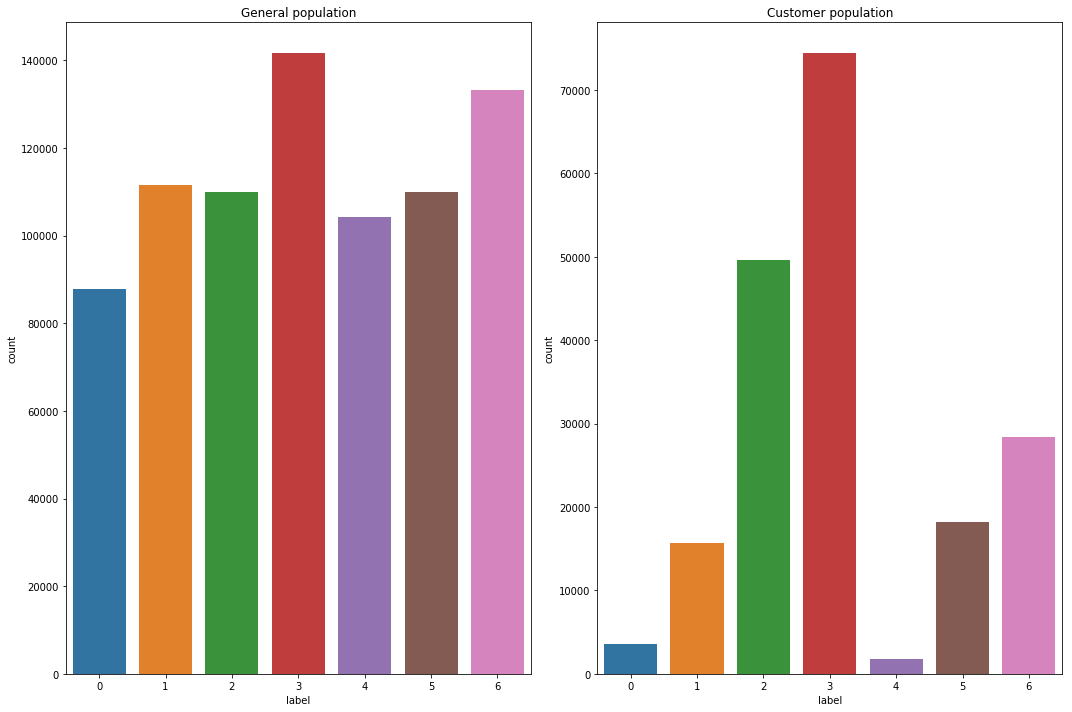

In [114]:
# Make countplot for general demographic for number in each category
# Make countplot for customer demographic for number in each category

fig, ax = plt.subplots(1, 2, figsize=(15,10))
sns.countplot(x='label', data=labels_7_df, ax = ax[0])
sns.countplot(x='label', data=labels_cust_df, ax = ax[1])
ax[0].set_title('General population')
ax[1].set_title('Customer population')
fig.tight_layout()
plt.show()

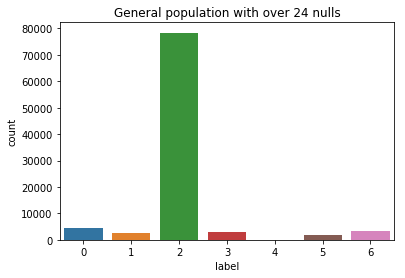

In [115]:
# Make countplot for general demographic for over 24 nulls in each category
sns.countplot(data=labels_over24nulls_df, x='label').set(title='General population with over 24 nulls');

In [116]:
# Compute proportions
def label_proportions(df):
    """
    Computes the proportion of data points in each cluster for a dataframe
    """
    prop_dict = {}
    
    for value in df['label'].unique():
        percent = (df[df['label']==value].count()/df.shape[0]*100)
        percent = list(percent)
        
        prop_dict[value]=percent
        
    prop_df = pd.DataFrame.from_dict(prop_dict, orient='index', columns=['percentage'])

    return prop_df

In [117]:
# Proportions for labels_4_df
df_gen_prop = label_proportions(labels_7_df)
df_gen_prop

,percentage
4,13.066884
2,13.764230
6,16.684314
5,13.773754
0,10.994392
3,17.740171
1,13.976254


In [118]:
print(df_gen_prop.index)

Int64Index([4, 2, 6, 5, 0, 3, 1], dtype='int64')


In [119]:
# Proportions for labels_cust_df
df_cust_prop = label_proportions(labels_cust_df)
df_cust_prop

,percentage
3,38.820884
1,8.174712
5,9.494814
6,14.799219
4,0.933985
2,25.892764
0,1.883622


In [120]:
# Proportions for labels_over24nulls_df
df_over24nulls_prop = label_proportions(labels_over24nulls_df)
df_over24nulls_prop

,percentage
2,84.113052
6,3.464741
0,4.666509
1,2.575218
3,3.227606
5,1.951801
4,0.001073


In [121]:
# Proportions for labels_over24nulls_df
df_over24nulls_prop = label_proportions(labels_over24nulls_df)
df_over24nulls_prop

,percentage
2,84.113052
6,3.464741
0,4.666509
1,2.575218
3,3.227606
5,1.951801
4,0.001073


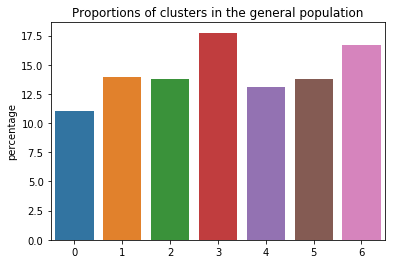

In [122]:
# Barplot of proportions of clusters in the general population
sns.barplot(data=df_gen_prop, x=df_gen_prop.index, y='percentage').set(title='Proportions of clusters in the general population');

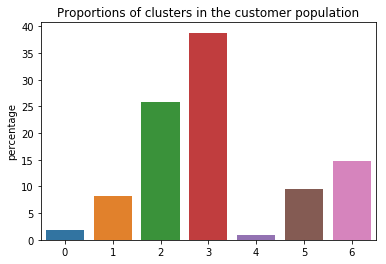

In [123]:
# Barplot of proportions of clusters in the customer population
sns.barplot(data=df_cust_prop, x=df_cust_prop.index, y='percentage').set(title='Proportions of clusters in the customer population');

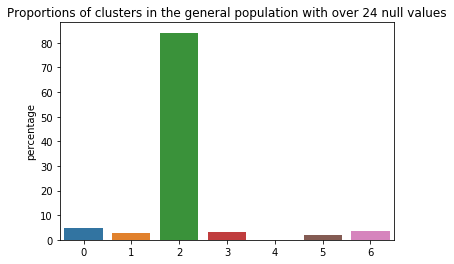

In [124]:
# Barplot of proportions of clusters in the general population with over 24 null values
sns.barplot(data=df_over24nulls_prop, x=df_over24nulls_prop.index, y='percentage').set(title='Proportions of clusters in the general population with over 24 null values');

In [125]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# from https://www.kaggle.com/questions-and-answers/126032
overrep_3 =scale.inverse_transform(pca.inverse_transform(kmeans_7.cluster_centers_[3]))
overrep_3

array([  3.29745826e+00,   1.08588969e+00,   4.63874044e+00,
         1.67431146e+00,   4.19404907e+00,   1.90717608e+00,
         2.00465265e+00,   2.02542129e+00,   3.84370896e-01,
         2.21055087e+00,   2.20044267e+01,   6.48464646e+00,
         3.85263921e+00,   5.02227144e+00,   4.73968752e+00,
         3.65099253e+00,   3.66867492e+00,   6.01952541e+00,
         4.96921239e+00,   4.28651203e+00,   4.80488510e+00,
         2.66937858e+00,   3.53143462e+00,   3.24494850e+00,
         2.67633548e+00,   3.27760360e+00,   3.02558536e+00,
         9.03693017e-03,   1.56173683e+00,   2.04245152e+00,
         5.87578578e-03,   3.26230148e+00,   4.13630157e+00,
         8.36450221e+00,   2.17069813e+00,   9.88489887e-03,
         3.77874186e+00,   1.99379149e+03,   4.50571491e+00,
         2.53334687e+00,   1.11784129e+00,   1.24785184e-01,
         3.66957076e-02,   4.08130120e+00,   4.86930475e+00,
         2.99945123e+00,   5.44669728e+00,   4.02896152e+00,
         2.62124547e+00,

In [133]:
# Apply inverse_transform to cluster 3, overrepresented in customer population
# Code from mentor Rajat
# Data in overrepresented cluster

overrep_3 = 3
cust_overrep_3 = scale.inverse_transform(pca.inverse_transform(customer_pca[np.where(labels_cust== overrep_3)])).round()
cust_overrep_3

array([[ 4.,  1.,  5., ...,  1.,  1.,  3.],
       [ 4.,  1.,  4., ...,  0.,  3.,  3.],
       [ 4.,  1.,  5., ..., -0.,  2.,  4.],
       ..., 
       [ 3.,  1.,  5., ...,  1.,  2.,  5.],
       [ 4.,  1.,  5., ...,  1.,  2.,  4.],
       [ 2.,  1.,  5., ..., -0.,  2.,  2.]])

In [136]:
# Code from mentor Rajat
# Attach labels to the above array and create a dataframe
df_cust_overrep_3 = pd.DataFrame(data=cust_overrep_3, index=np.array(range(0, cust_overrep_3.shape[0])), columns= customers_copy.columns)
df_cust_overrep_3.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,O,W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,5.0,1.0,2.0,1.0,-0.0,1.0,56.0,1.0,1.0,3.0
1,4.0,1.0,4.0,1.0,4.0,1.0,2.0,2.0,0.0,1.0,...,3.0,3.0,5.0,3.0,0.0,1.0,64.0,0.0,3.0,3.0
2,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,-0.0,2.0,...,4.0,1.0,2.0,1.0,-0.0,1.0,57.0,-0.0,2.0,4.0
3,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,5.0,4.0,6.0,4.0,-0.0,1.0,58.0,1.0,2.0,4.0
4,3.0,1.0,5.0,1.0,6.0,1.0,1.0,3.0,1.0,2.0,...,5.0,2.0,3.0,2.0,0.0,1.0,55.0,1.0,2.0,3.0


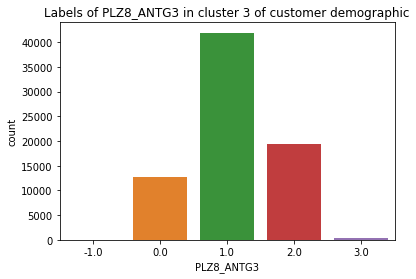

In [138]:
# Count of labels of PLZ8_ANTG3 in cluster 3 of customer demographic
# Dimension 1
# Positive correlation with PLZ8_ANTG4
sns.countplot(data=df_cust_overrep_3, x='PLZ8_ANTG3').set(title='Labels of PLZ8_ANTG3 in cluster 3 of customer demographic');

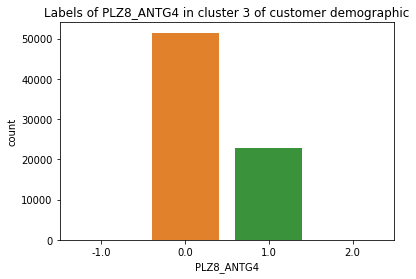

In [139]:
# Count of labels of PLZ8_ANTG4 in cluster 3 of customer demographic
# Dimension 1
# Positive correlation with PLZ8_ANTG3
sns.countplot(data=df_cust_overrep_3, x='PLZ8_ANTG4').set(title='Labels of PLZ8_ANTG4 in cluster 3 of customer demographic');

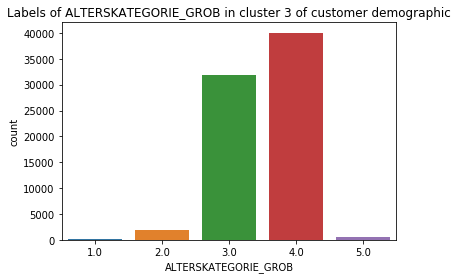

In [148]:
# Count of labels of ALTERSKATEGORIE_GROB in cluster 3 of customer demographic
# Dimension 2
# Positive correlation with FINANZ_VORSORGER
sns.countplot(data=df_cust_overrep_3, x='ALTERSKATEGORIE_GROB').set(title='Labels of ALTERSKATEGORIE_GROB in cluster 3 of customer demographic');

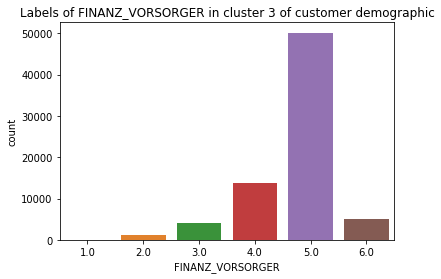

In [150]:
# Count of labels of FINANZ_VORSORGER in cluster 3 of customer demographic
# Dimension 2
# Positive correlation with ALTERSKATEGORIE_GROB
sns.countplot(data=df_cust_overrep_3, x='FINANZ_VORSORGER').set(title='Labels of FINANZ_VORSORGER in cluster 3 of customer demographic');

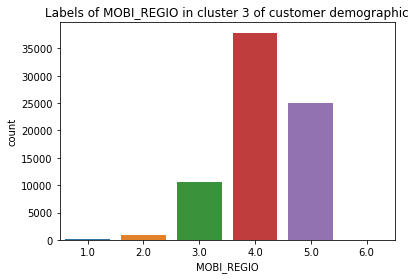

In [140]:
# Count of labels of MOBI_REGIO in cluster 3 of customer demographic
# Dimension 1
# Negative correlation with PLZ8_ANTG3,PLZ8_ANTG4
sns.countplot(data=df_cust_overrep_3, x='MOBI_REGIO').set(title='Labels of MOBI_REGIO in cluster 3 of customer demographic');

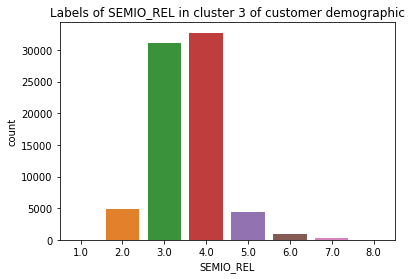

In [143]:
# Count of labels of 'SEMIO_REL' in cluster 3 of customer demographic
# Dimension 2
# Negative correlation with ALTERSKATEGORIE_GROB, FINANZ_VORSORGER
sns.countplot(data=df_cust_overrep_3, x='SEMIO_REL').set(title='Labels of SEMIO_REL in cluster 3 of customer demographic');

In [130]:
#'PLZ8_ANTG3','PLZ8_ANTG4','MOBI_REGIO', 'ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER','SEMIO_REL'

In [144]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Apply inverse_transform to cluster 4, underrepresented in customer population
# Code from mentor Rajat
# Data in underrepresented cluster

underrep_4 = 4
cust_underrep_4 = scale.inverse_transform(pca.inverse_transform(customer_pca[np.where(labels_cust== underrep_4)])).round()
cust_underrep_4

array([[ 2.,  1.,  2., ...,  0.,  5.,  2.],
       [ 2.,  2.,  2., ..., -0.,  5.,  1.],
       [ 2.,  1.,  2., ..., -0.,  5.,  1.],
       ..., 
       [ 2.,  2.,  2., ...,  0.,  4.,  1.],
       [ 1.,  2.,  2., ..., -0.,  4.,  5.],
       [ 1.,  2.,  3., ...,  1.,  4.,  1.]])

In [145]:
# Code from mentor Rajat
# Attach labels to the above array and create a dataframe
df_cust_underrep_4 = pd.DataFrame(data=cust_underrep_4, index=np.array(range(0, cust_underrep_4.shape[0])), columns= customers_copy.columns)
df_cust_underrep_4.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,O,W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1.0,2.0,4.0,3.0,3.0,4.0,3.0,0.0,1.0,...,1.0,3.0,9.0,4.0,-0.0,1.0,85.0,0.0,5.0,2.0
1,2.0,2.0,2.0,2.0,4.0,2.0,1.0,5.0,-0.0,2.0,...,3.0,4.0,9.0,3.0,1.0,0.0,61.0,-0.0,5.0,1.0
2,2.0,1.0,2.0,5.0,1.0,4.0,3.0,4.0,-0.0,3.0,...,2.0,4.0,8.0,3.0,1.0,-0.0,93.0,-0.0,5.0,1.0
3,2.0,2.0,1.0,4.0,2.0,5.0,3.0,5.0,0.0,2.0,...,3.0,4.0,7.0,3.0,1.0,0.0,79.0,0.0,4.0,4.0
4,2.0,1.0,1.0,3.0,4.0,2.0,1.0,5.0,0.0,2.0,...,0.0,3.0,10.0,4.0,-0.0,1.0,70.0,0.0,7.0,2.0


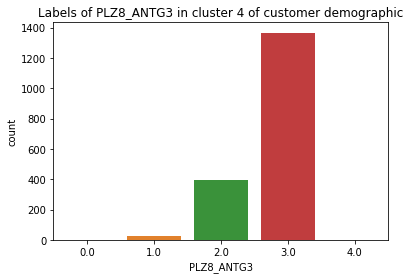

In [146]:
# Count of labels of PLZ8_ANTG3 in cluster 4 of customer demographic
# Dimension 1
# Positive correlation with PLZ8_ANTG4
sns.countplot(data=df_cust_underrep_4, x='PLZ8_ANTG3').set(title='Labels of PLZ8_ANTG3 in cluster 4 of customer demographic');

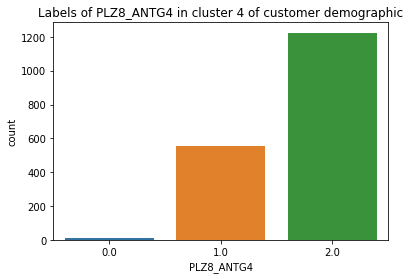

In [147]:
# Count of labels of PLZ8_ANTG4 in cluster 4 of customer demographic
# Dimension 1
# Positive correlation with PLZ8_ANTG3
sns.countplot(data=df_cust_underrep_4, x='PLZ8_ANTG4').set(title='Labels of PLZ8_ANTG4 in cluster 4 of customer demographic');

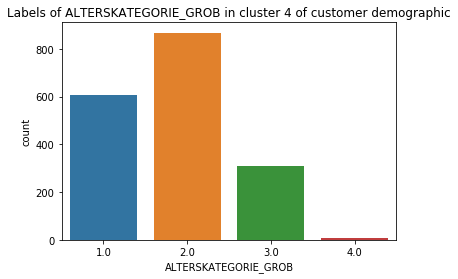

In [149]:
# Count of labels of ALTERSKATEGORIE_GROB in cluster 4 of customer demographic
# Dimension 2
# Positive correlation with 'FINANZ_VORSORGER'
sns.countplot(data=df_cust_underrep_4, x='ALTERSKATEGORIE_GROB').set(title='Labels of ALTERSKATEGORIE_GROB in cluster 4 of customer demographic');

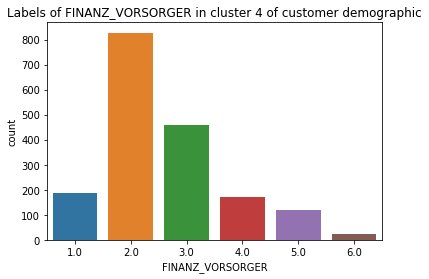

In [151]:
# Count of labels of FINANZ_VORSORGER in cluster 4 of customer demographic
# Dimension 2
# Positive correlation with ALTERSKATEGORIE_GROB
sns.countplot(data=df_cust_underrep_4, x='FINANZ_VORSORGER').set(title='Labels of FINANZ_VORSORGER in cluster 4 of customer demographic');

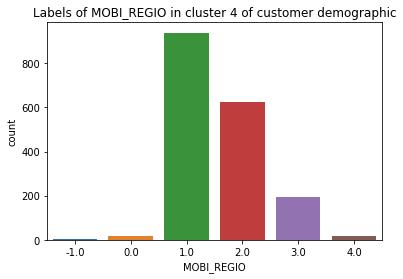

In [152]:
# Count of labels of MOBI_REGIO in cluster 4 of customer demographic
# Dimension 1
# Negative correlation with PLZ8_ANTG3,PLZ8_ANTG4
sns.countplot(data=df_cust_underrep_4, x='MOBI_REGIO').set(title='Labels of MOBI_REGIO in cluster 4 of customer demographic');

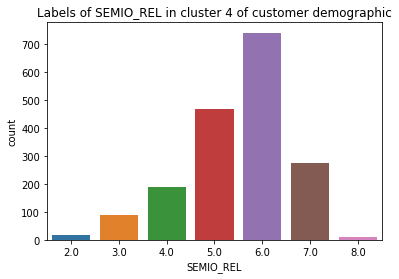

In [153]:
# Count of labels of 'SEMIO_REL' in cluster 4 of customer demographic
# Dimension 2
# Negative correlation with ALTERSKATEGORIE_GROB, FINANZ_VORSORGER
sns.countplot(data=df_cust_underrep_4, x='SEMIO_REL').set(title='Labels of SEMIO_REL in cluster 4 of customer demographic');

### Discussion 3.3: Compare Customer Data to Demographics Data

The countplots of the clusters in each dataset, which count the total number of data points in each cluster, show cluster 3 being overrepresented in the Customer population and cluster 4 being underrepresented in the Customer population relative to the General population. In the General population where there are more than 24 null values, cluster 2 is overrepresented relative to the other 2 datasets.

This finding is duplicated in the proportional computations, plotted on a bar chart. The bar charts of the clusters in each dataset, which show the percentage of the total number of data points in each cluster, show cluster 3 being overrepresented in the Customer population and cluster 4 being underrepresented in the Customer population relative to the General population. In the General population where there are more than 24 null values, cluster 2 is overrepresented relative to the other 2 datasets.

Since cluster 3, is overrepresented in the Customer population relative to the General population, this category was further analyzed for the most common label, or type of person represented in this cluster, using the columns representing the two highest variances and the lowest variance calculated in Dimensions 1 and 2 of the Principal Component analysis.

The columns that have the strongest positive correlation with Dimension 1 are 'PLZ8_ANTG3' and 'PLZ8_ANTG4.' In cluster 3,
'PLZ8_ANTG3' has the greatest representation of label 1, meaning that the PLZ8 region has a "lower share of 6-10 family homes." 
'PLZ8_ANTG4' has the greatest representation of label 0, meaning that it has "no 10+ family homes."

The columns that have the strongest positive correlation with Dimension 2 are 'ALTERSKATEGORIE_GROB' and 'FINANZ_VORSORGER.' In cluster 3, 'ALTERSKATEGORIE_GROB' has the greatest representation of label 4, meaning that they are "> 60 years old." 
'FINANZ_VORSORGER,' with the greatest representation of label 5, means that these customers have "very low" levels of financial preparation.

The column that has the strongest negative correlation with Dimension 1 is MOBI_REGIO with the greatest representation of label 4, means that these customers have "very low movement patterns. 

The column that has the strongest negative correlation with Dimension 2 is 'SEMIO_REL,' with the greatest representation of label 4, means that these customers have average religious affinity.




(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.